In [1]:
import os
import sys
import numpy as np
import pandas as pd
from numpy import random as npr
import time
import torch

from plotly import graph_objects as go
import plotly.io as pio

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['text.usetex'] = True

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
SEED = 2021
BOOKS_DATASET_PATH = r"/../../data/books_dataset.csv"
REAL_DATASET_SAMPLE_SIZE = 0.05
CACHE_DIR = "./cache"
SYNTHETIC_USERS_COUNT = 100
SYNTHETIC_ITEMS_COUNT = 100
SAMPLE_SIZES = [0.1, 0.3, 0.5, 0.9]
ALPHA_SAMPLE_RATE = 20
CTGAN_EPOCHS = 10

npr.seed(SEED)

# 1. Load and prepare data

In [7]:
real_dataset = pd.read_csv(module_path + BOOKS_DATASET_PATH)
real_dataset = real_dataset[real_dataset.book_rating != 0]
npr.seed(SEED)
real_dataset = real_dataset.sample(frac=REAL_DATASET_SAMPLE_SIZE)

real_dataset = real_dataset.drop(["Location", "rating_sum", "Book_Title", "Count_All_Rate", "Country", "Book_Author", "Publisher"], axis=1)
real_dataset["ISBN"] = real_dataset["ISBN"].astype('category').cat.codes
real_dataset.shape

(19192, 6)

In [4]:
df_deepfm = pd.read_csv(module_path + BOOKS_DATASET_PATH)
df_deepfm = df_deepfm[df_deepfm.book_rating != 0]

df_deepfm = df_deepfm.drop(["Location", "rating_sum", "Book_Title", "Count_All_Rate", "Country", "Book_Author", "Publisher"], axis=1)
df_deepfm["ISBN"] = df_deepfm["ISBN"].astype('category').cat.codes
df_deepfm.shape

(383842, 6)

In [5]:
df_deepfm = df_deepfm.reset_index(drop=True)
real_dataset = real_dataset.reset_index(drop=True)

In [6]:
users_df = real_dataset[['user_id', 'Age']]
books_df = real_dataset[['ISBN', 'rating_Avg', 'Year_Of_Publication']]

users_df = users_df.drop_duplicates()
books_df = books_df.drop_duplicates()

# 2. Generate synthetic data and train DeepFM components


In [8]:
from sdv.tabular import CTGAN, GaussianCopula, CopulaGAN
import time

def _clean_dataset_books(df):
    df = df.drop(["ISBN"], axis=1)
    return df


def fit_and_evaluate_models_books(df, models, sample_size, eval_kwargs):
    result = pd.DataFrame()
    for name, model in models.items():
        start = time.time()
        model.fit(df)
        model.save(r"/../books_models/" + str(name) + '_books.pkl')
        end = time.time()
        print("Fitting of " + name)
        print(end - start)
        eval_result = evaluate(df, model.sample(sample_size), **eval_kwargs)
        eval_result["model_name"] = name
        eval_result["time"] = end-start
        result = pd.concat([result, eval_result])
    
    return result


def _clean_dataset_users(df):
    df = df.drop(["user_id"], axis=1) # Drop ids
    return df


def fit_and_evaluate_models_users(df, models, sample_size, eval_kwargs):
    result = pd.DataFrame()
    for name, model in models.items():
        start = time.time()
        model.fit(df)
        model.save(r"/../books_models/"  + str(name) + '_users.pkl')
        end = time.time()
        print("Fitting of " + name)
        print(end - start)
        eval_result = evaluate(df, model.sample(sample_size), **eval_kwargs)
        eval_result["model_name"] = name
        eval_result["time"] = end-start
        result = pd.concat([result, eval_result])
    
    return result

In [15]:
from sdv.evaluation import evaluate

with torch.cuda.device(1):
    _comp_result_users = fit_and_evaluate_models_users(
        df=_clean_dataset_users(users_df),
        models={"GaussianCopula": GaussianCopula(), 
            "CTGAN": CTGAN(verbose=True), "CopulaGAN": CopulaGAN(verbose=True)},
        sample_size=1_000,
        eval_kwargs={"aggregate": False}
    )

/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4798: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Fitting of GaussianCopula
2.3971619606018066


/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/sdmetrics/single_table/multi_column_pairs.py:76: RuntimeWarning: Mean of empty slice
  return np.nanmean(values)
/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Epoch 1, Loss G: -0.0314, Loss D:  0.0353
Epoch 2, Loss G: -0.2752, Loss D:  0.1492
Epoch 3, Loss G: -0.2623, Loss D:  0.0508
Epoch 4, Loss G: -0.1645, Loss D: -0.0219
Epoch 5, Loss G:  0.0101, Loss D: -0.1544
Epoch 6, Loss G: -0.0498, Loss D: -0.0878
Epoch 7, Loss G: -0.4363, Loss D:  0.1960
Epoch 8, Loss G: -0.4417, Loss D:  0.0341
Epoch 9, Loss G: -0.3747, Loss D:  0.0303
Epoch 10, Loss G: -0.3811, Loss D:  0.0690
Epoch 11, Loss G: -0.4658, Loss D:  0.0081
Epoch 12, Loss G: -0.4604, Loss D: -0.0322
Epoch 13, Loss G: -0.4161, Loss D: -0.0204
Epoch 14, Loss G: -0.4298, Loss D:  0.0771
Epoch 15, Loss G: -0.4450, Loss D: -0.0162
Epoch 16, Loss G: -0.5031, Loss D:  0.0124
Epoch 17, Loss G: -0.4972, Loss D:  0.0067
Epoch 18, Loss G: -0.5138, Loss D: -0.0220
Epoch 19, Loss G: -0.6242, Loss D: -0.1327
Epoch 20, Loss G: -0.4984, Loss D: -0.1202
Epoch 21, Loss G: -0.5393, Loss D: -0.2108
Epoch 22, Loss G: -0.6288, Loss D:  0.1163
Epoch 23, Loss G: -0.5326, Loss D: -0.0598
Epoch 24, Loss G: -0

/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/sdmetrics/single_table/multi_column_pairs.py:76: RuntimeWarning: Mean of empty slice
  return np.nanmean(values)
/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4798: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid valu

Epoch 1, Loss G: -0.2042, Loss D:  0.0596
Epoch 2, Loss G: -0.2187, Loss D:  0.0324
Epoch 3, Loss G: -0.3071, Loss D:  0.0452
Epoch 4, Loss G: -0.1086, Loss D: -0.2492
Epoch 5, Loss G: -0.3944, Loss D:  0.0152
Epoch 6, Loss G: -0.1713, Loss D: -0.1235
Epoch 7, Loss G: -0.1260, Loss D: -0.1899
Epoch 8, Loss G: -0.4562, Loss D:  0.1733
Epoch 9, Loss G: -0.5644, Loss D:  0.1192
Epoch 10, Loss G: -0.4686, Loss D: -0.1135
Epoch 11, Loss G: -0.4228, Loss D: -0.0945
Epoch 12, Loss G: -0.6041, Loss D:  0.0063
Epoch 13, Loss G: -0.5864, Loss D: -0.0368
Epoch 14, Loss G: -0.3989, Loss D: -0.0869
Epoch 15, Loss G: -0.5887, Loss D: -0.0062
Epoch 16, Loss G: -0.6025, Loss D:  0.0292
Epoch 17, Loss G: -0.4975, Loss D: -0.1207
Epoch 18, Loss G: -0.6007, Loss D: -0.0711
Epoch 19, Loss G: -0.6427, Loss D:  0.1148
Epoch 20, Loss G: -0.6203, Loss D:  0.0201
Epoch 21, Loss G: -0.5540, Loss D: -0.0247
Epoch 22, Loss G: -0.6473, Loss D: -0.0757
Epoch 23, Loss G: -0.5638, Loss D: -0.0606
Epoch 24, Loss G: -0

/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/sdmetrics/single_table/multi_column_pairs.py:76: RuntimeWarning: Mean of empty slice
  return np.nanmean(values)


In [16]:
_comp_result_books = fit_and_evaluate_models_books(
    df=_clean_dataset_books(books_df),
    models={"GaussianCopula": GaussianCopula(), 
        "CTGAN": CTGAN(verbose=True), "CopulaGAN": CopulaGAN(verbose=True)},
    sample_size=1_000,
    eval_kwargs={"aggregate": False}
)

/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4798: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Fitting of GaussianCopula
15.16994047164917


/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Epoch 1, Loss G: -0.3419, Loss D:  0.0357
Epoch 2, Loss G: -0.4172, Loss D:  0.0173
Epoch 3, Loss G: -0.2701, Loss D: -0.1412
Epoch 4, Loss G: -0.2675, Loss D: -0.1482
Epoch 5, Loss G: -0.3156, Loss D: -0.0425
Epoch 6, Loss G: -0.4634, Loss D: -0.0679
Epoch 7, Loss G: -0.6808, Loss D:  0.1365
Epoch 8, Loss G: -0.7719, Loss D:  0.0951
Epoch 9, Loss G: -0.7966, Loss D:  0.0281
Epoch 10, Loss G: -0.6106, Loss D: -0.1179
Epoch 11, Loss G: -0.8081, Loss D: -0.0124
Epoch 12, Loss G: -0.8040, Loss D:  0.0739
Epoch 13, Loss G: -0.9333, Loss D: -0.0967
Epoch 14, Loss G: -0.7329, Loss D:  0.0025
Epoch 15, Loss G: -0.8512, Loss D:  0.0923
Epoch 16, Loss G: -0.8978, Loss D: -0.0656
Epoch 17, Loss G: -0.9736, Loss D: -0.0247
Epoch 18, Loss G: -0.8816, Loss D: -0.0423
Epoch 19, Loss G: -0.9649, Loss D:  0.0804
Epoch 20, Loss G: -0.9847, Loss D:  0.0175
Epoch 21, Loss G: -0.9660, Loss D:  0.0131
Epoch 22, Loss G: -1.0556, Loss D: -0.0938
Epoch 23, Loss G: -1.1311, Loss D: -0.0476
Epoch 24, Loss G: -0

/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4798: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initia

Epoch 1, Loss G: -0.1573, Loss D:  0.0309
Epoch 2, Loss G: -0.1862, Loss D: -0.1112
Epoch 3, Loss G: -0.3384, Loss D:  0.0126
Epoch 4, Loss G: -0.2539, Loss D: -0.0452
Epoch 5, Loss G: -0.1582, Loss D: -0.2673
Epoch 6, Loss G: -0.4079, Loss D: -0.0086
Epoch 7, Loss G: -0.5501, Loss D:  0.0715
Epoch 8, Loss G: -0.6161, Loss D:  0.0443
Epoch 9, Loss G: -0.6081, Loss D: -0.0080
Epoch 10, Loss G: -0.6710, Loss D: -0.0085
Epoch 11, Loss G: -0.7449, Loss D: -0.0953
Epoch 12, Loss G: -0.8110, Loss D:  0.0295
Epoch 13, Loss G: -0.8321, Loss D: -0.0156
Epoch 14, Loss G: -0.8210, Loss D: -0.0752
Epoch 15, Loss G: -0.6914, Loss D: -0.0357
Epoch 16, Loss G: -0.9123, Loss D:  0.0580
Epoch 17, Loss G: -0.8687, Loss D: -0.1056
Epoch 18, Loss G: -0.8952, Loss D: -0.0857
Epoch 19, Loss G: -0.8427, Loss D: -0.0352
Epoch 20, Loss G: -0.9013, Loss D:  0.0262
Epoch 21, Loss G: -0.9243, Loss D:  0.0040
Epoch 22, Loss G: -0.8712, Loss D: -0.0371
Epoch 23, Loss G: -0.8622, Loss D:  0.0200
Epoch 24, Loss G: -0

In [17]:
rs = _comp_result_users[
    (_comp_result_users.metric == "LogisticDetection") |
    (_comp_result_users.metric == "SVCDetection") |
    (_comp_result_users.metric == "KSTest") 
]

rs=rs.append(pd.DataFrame({'metric' : ['FitTime']*3, 
                        'raw_score' : [0.9815258613278761, 0.49744124242014476, 0.521032896251979],
                        'model_name' : ['GaussianCopula', 'CTGAN', 'CopulaGAN']}))

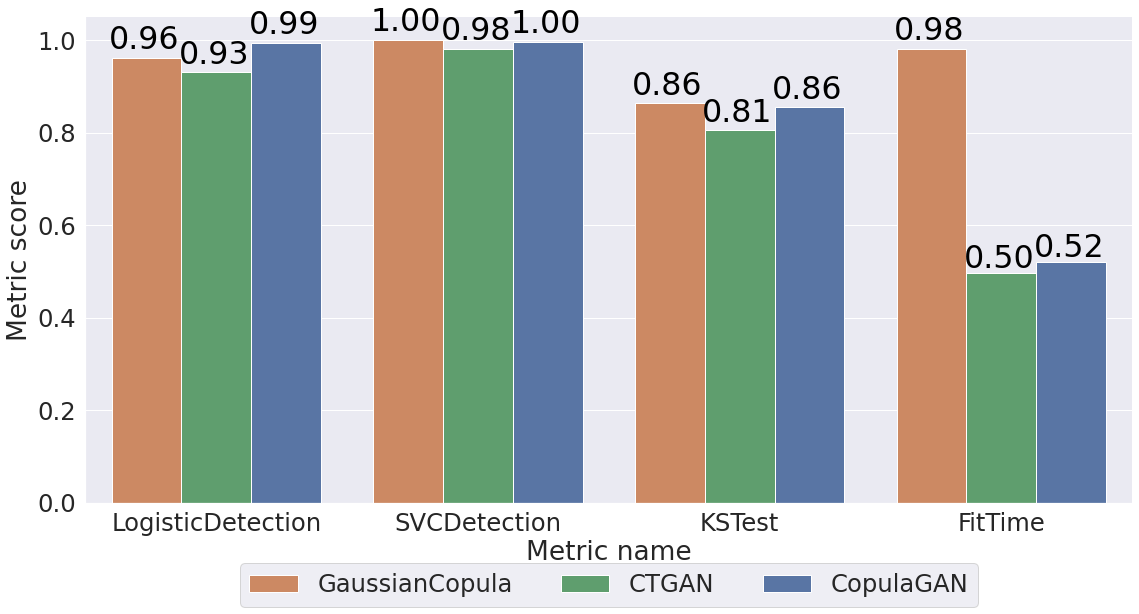

In [18]:
import matplotlib
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
rs["Model name"] = rs["model_name"]
rs["Metric score"] = rs["raw_score"]
rs["Metric name"] = rs["metric"]
rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=2.2)  # crazy big
plot = sns.catplot(data=rs, x="Metric name", y="Metric score", hue="Model name", kind="bar", aspect=2, height=8, palette=[
    "C1", "C2", "C0"
], legend=False)
ax = plot.facet_axis(0,0)
hist_values = [rs.iloc[0, 2], rs.iloc[1, 2], rs.iloc[2, 2], rs.iloc[9, 2],
               rs.iloc[3, 2], rs.iloc[4, 2], rs.iloc[5, 2], rs.iloc[10, 2],
               rs.iloc[6, 2], rs.iloc[7, 2], rs.iloc[8, 2], rs.iloc[11, 2]]
for (p, val) in zip(ax.patches, hist_values):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   #Used to format it K representation
            color='black', 
            rotation='horizontal', 
            size='large')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=3)

In [19]:

rs = _comp_result_books[
    (_comp_result_books.metric == "LogisticDetection") |
    (_comp_result_books.metric == "SVCDetection") |
    (_comp_result_books.metric == "KSTest") 
]

rs=rs.append(pd.DataFrame({'metric' : ['FitTime']*3, 
                        'raw_score' : [0.9389733106749408, 0.5633803471084302, 0.49764634221662907],
                        'model_name' : ['GaussianCopula', 'CTGAN', 'CopulaGAN']}))

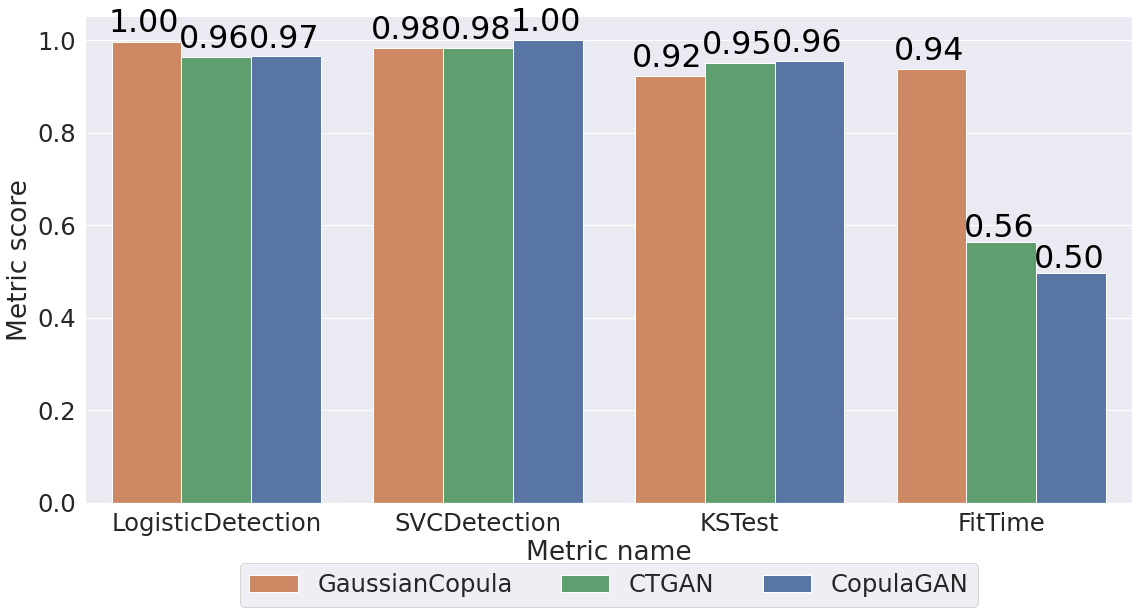

In [20]:
import matplotlib
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
rs["Model name"] = rs["model_name"]
rs["Metric score"] = rs["raw_score"]
rs["Metric name"] = rs["metric"]
rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=2.2)  # crazy big
plot = sns.catplot(data=rs, x="Metric name", y="Metric score", hue="Model name", kind="bar", aspect=2, height=8, palette=[
    "C1", "C2", "C0"
], legend=False)
ax = plot.facet_axis(0,0)
hist_values = [rs.iloc[0, 2], rs.iloc[1, 2], rs.iloc[2, 2], rs.iloc[9, 2],
               rs.iloc[3, 2], rs.iloc[4, 2], rs.iloc[5, 2], rs.iloc[10, 2],
               rs.iloc[6, 2], rs.iloc[7, 2], rs.iloc[8, 2], rs.iloc[11, 2]]
for (p, val) in zip(ax.patches, hist_values):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   #Used to format it K representation
            color='black', 
            rotation='horizontal', 
            size='large')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=3)